---
# <span style="color:blue">**Logistic Regression**</span>
---

---
### **Load merged training and validation data & test data**
---

In [1]:
import functions as fn

X_te, y_te, y_te_labels, test_features, te_filenames = fn.load_data('testfile_mobile_v2.npz', 'Test')
X_tr_merged, y_tr_merged, y_tr_labels_merged, train_features_merged, train_filenames_merged = fn.merge_tr_val_sets()

Test data info:
---------------
X: (50, 224, 224, 3)
y: (50, 6)
labels: (6,)
features: (50, 1280)
filenames (50,) 

Training data info:
-------------------
X: (280, 224, 224, 3)
y: (280, 6)
labels: (6,)
features: (280, 1280)
filenames (280,) 

Validation data info:
---------------------
X: (139, 224, 224, 3)
y: (139, 6)
labels: (6,)
features: (139, 1280)
filenames (139,) 

merged training and validation data info:
-----------------------------------------
X: (419, 224, 224, 3)
y: (419, 6)
labels: (6,)
features: (419, 1280)
filenames (419,) 



---
### **Get new y arrays for the different sets by converting the one-hot encoding values to the corresponding labels numbered [0,5]**
---

In [2]:
import numpy as np

y_tr_indices = np.where(y_tr_merged == 1)[1]
y_te_indices = np.where(y_te == 1)[1]

---
### **Logistic regression without hypermaters tuning**
---

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(
    #StandardScaler(), 
    LogisticRegression(solver='liblinear', multi_class='ovr'))

# Fit it to train data
logreg.fit(train_features_merged, y_tr_indices)

# Accuracy on test set
accuracy = logreg.score(test_features, y_te_indices)
print('Test accuracy: {:.2f}'.format(accuracy))

Test accuracy: 0.92


---
### **Tune Logistic regression**
---

In [4]:
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression estimator
logreg = LogisticRegression(multi_class='ovr')

# Define parameters to search
parameters_logreg = {
    #'penalty': ('l1', 'l2', 'elasticnet', 'none'),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'C': (100, 10, 1.0, 0.1, 0.01),
}
                   
# Define GridSearch
grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=parameters_logreg,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10
)

# Fit GridSearchCV
grid_search_logreg.fit(train_features_merged, y_tr_indices)

# Print results
print('Best paramemeters:',grid_search_logreg.best_params_) 
print('Best validation score:{:.2f}'.format(grid_search_logreg.best_score_))

/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramemeters: {'C': 10, 'solver': 'newton-cg'}
Best validation score:0.91


---
### **Fit Logistic regression with best params**
---

In [5]:
#log_reg_best_params = LogisticRegression(multi_class='ovr',
#                                         solver = grid_search_logreg.best_params_['solver'],
#                                         C = grid_search_logreg.best_params_['C'])

# Fit 
#log_reg_best_params.fit(train_features_merged, y_tr_indices)

print('Test accuracy with best parameters:', grid_search_logreg.score(test_features, y_te_indices))

Test accuracy with best parameters: 0.94


---
### **Save test accuracy**
---

In [6]:
fn.save_test_accuracy('logistic.csv','logistic', grid_search_logreg.score(test_features, y_te_indices))

---
### **Pick 10 random images and compute probabilities**
---

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Define function to plot and produce the dataframe with the prediction results
def plot_images(indices, reg, plot_images=False):

    gs_results = []

    # Plot the images
    if plot_images:
        
        plotnumber = 1    
        plt.figure(figsize=(20,10))
        
        for idx in indices:

            if plotnumber<=len(indices) :

                ax = plt.subplot(1,10,plotnumber)
                plt.imshow(X_te[idx])      
                ax.get_xaxis().set_visible(False) # disable x-axis
                ax.get_yaxis().set_visible(False) # disable y-axis 
                ax.set_title(te_filenames[idx])
                plotnumber+=1
           # plt.tight_layout()
    
    # For the dataframe
    for idx in indices:
        
        predictions = reg.predict_proba([test_features[idx]])
        
        # Create the dataframe
        data = pd.DataFrame(predictions, columns = y_te_labels)
        data['fname'] = te_filenames[idx]

        gs_results.append(data)
    
    df_cn = pd.concat(gs_results)
    df_cn = df_cn.set_index(df_cn['fname'])
    df_cn.drop('fname', axis=1, inplace=True)
       
    return df_cn

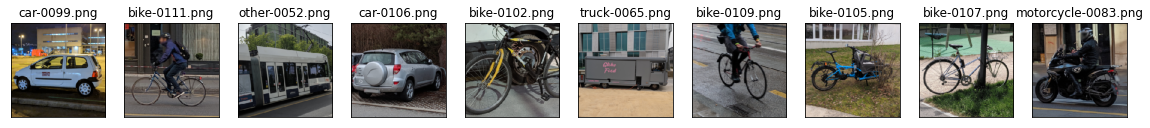

In [8]:
import random

# Generate 10 random indexes with max size equals to the test samples
img_indices = random.sample(range(0, y_te.shape[0]), 10)

# Call function to plot the images
df_prob = plot_images(img_indices, log_reg_best_params, plot_images=True)

In [9]:
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
display(df_prob) 

,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.75,0.00,0.00,0.00,0.25
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.84,0.16,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.98,0.00,0.01,0.01,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00


---
    From the above test we see that the logistic regression with a regularization strength equals to 10, gave correct predictions with a probability of >98% for 8 out of the 10 images. While:
    - for the first image 'car-0099' the prediction is in between a car and a van with a probability of 75% and 25% respectively. 
    - for the sixth image 'truck-0065' the prediction is in between the category 'other and the truck with probabilities 84% and 16% respectively.
---

---
### **Vary the regularization strength of the estimator**
---

In [10]:
#c =  grid_search_logreg.best_params_['C']
#c_nums = list(np.arange(c/2,c*2,1))
c_nums = [100, 50, 20, 10, 5, 1]

for c in c_nums:
    # Define the estimator
    log_reg_cvary = LogisticRegression(multi_class='ovr',
                                       solver = grid_search_logreg.best_params_['solver'],
                                       C = c,
                                       max_iter=100)

    # Fit 
    log_reg_cvary.fit(train_features_merged, y_tr_indices)

    # Calculate probabilities
    df_prob = plot_images(img_indices, log_reg_cvary, plot_images=False)
    
    print('\033[1m Inverse of regularization strength={:.0f}\033[0m'.format(c))
    display(df_prob) 
    print('\n')

 Inverse of regularization strength=100


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.77,0.00,0.00,0.00,0.23
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.91,0.09,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.99,0.00,0.00,0.00,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00




 Inverse of regularization strength=50


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.76,0.00,0.00,0.00,0.24
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.89,0.11,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.99,0.00,0.00,0.00,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00




 Inverse of regularization strength=20


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.75,0.00,0.00,0.00,0.25
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.87,0.13,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.99,0.00,0.01,0.01,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00




 Inverse of regularization strength=10


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.75,0.00,0.00,0.00,0.25
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.84,0.16,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.98,0.00,0.01,0.01,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00




 Inverse of regularization strength=5


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.74,0.00,0.00,0.00,0.26
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,1.00,0.00,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.82,0.18,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.97,0.00,0.01,0.01,0.00,0.00
bike-0107.png,1.00,0.00,0.00,0.00,0.00,0.00




 Inverse of regularization strength=1


,bike,car,motorcycle,other,truck,van
fname,,,,,,
car-0099.png,0.00,0.73,0.00,0.00,0.00,0.27
bike-0111.png,1.00,0.00,0.00,0.00,0.00,0.00
other-0052.png,0.00,0.00,0.00,0.99,0.01,0.00
car-0106.png,0.00,1.00,0.00,0.00,0.00,0.00
bike-0102.png,1.00,0.00,0.00,0.00,0.00,0.00
truck-0065.png,0.00,0.00,0.00,0.74,0.26,0.00
bike-0109.png,1.00,0.00,0.00,0.00,0.00,0.00
bike-0105.png,0.94,0.00,0.03,0.03,0.00,0.00
bike-0107.png,0.99,0.00,0.00,0.01,0.00,0.00


---
    Varying the regularization strength of the logistic regression from vary high values (e.g. C=100) to very small (e.g. C=1) we see again that 8 out of the 10 images are classified correctly with a probability of >94%.
    - for the image car-0099 as the regularization strength decreases the probability for the correct prediction decreases within 4%
    - for the image truck-0065 as the regularization strength decreases the probability of this image to be classified as 'other' (which is much higher than of being classified as a truck) decreases within ~20%. 
---